In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


In [2]:


# 1. CONFIGURATION GLOBALE
class Config:
    """Configuration du modèle et des chemins."""
    # Modèle BERT-based adapté au calcul de similarité sémantique
    MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2' 
    CSV_PATH = 'data_complet.csv'
    BATCH_SIZE = 32  # Taille du lot pour l'encodage (optimisation mémoire)
    MAX_LENGTH = 128 # Longueur maximale de la séquence de tokens

# Variables globales pour la persistance en mémoire
df_movies = None
movie_title_to_index = None
movie_vectors_array = None 
# La matrice N x N de similarité n'est plus nécessaire car on la calcule 
# à la volée entre le vecteur utilisateur (1 x D) et les vecteurs bruts (N x D).

# 2. FONCTIONS D'UTILITAIRES ET DE PRÉPARATION

def mean_pooling(model_output, attention_mask):
    """
    Aggrège les vecteurs de tokens en un seul vecteur de phrase
    par la moyenne pondérée (manuel - l'étape "Option B").
    """
    # Récupère les embeddings bruts de tous les tokens
    token_embeddings = model_output.last_hidden_state
    
    # Étend le masque d'attention pour correspondre à la taille des embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    # Somme les embeddings (en multipliant par le masque, les zéros sont ignorés)
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    
    # Somme le masque (compte le nombre de tokens valides)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    # Retourne la moyenne
    return sum_embeddings / sum_mask

def prepare_feature_soup(df):
    """
    Nettoie les données et crée la chaîne de caractères structurée ('soup') 
    pour le modèle Transformer.
    """
    print(" Préparation de la Feature Soup...")
    
    # 1. Gestion des valeurs manquantes et nettoyage de base
    df['plot'] = df['plot'].fillna('')
    df['side_genre'] = df['side_genre'].fillna('')
    df['Director'] = df['Director'].fillna('Unknown')
    
    # Nettoyage des espaces excédentaires
    for col in ['main_genre', 'side_genre', 'Actors', 'Movie_Title', 'Director']:
        df[col] = df[col].astype(str).str.strip()
    
    # 2. Création de la "Soup" structurée pour le modèle
    df['soup'] = (
        "Title: " + df['Movie_Title'] + ". " +
        "Director: " + df['Director'] + ". " +
        "Genres: " + df['main_genre'] + ", " + df['side_genre'] + ". " +
        "Stars: " + df['Actors'] + ". " +
        "Plot: " + df['plot']
    )
    
    # Nettoyage final de la string
    df['soup'] = df['soup'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    print(f" Soup créée pour {len(df)} films.")
    return df

# 3. INITIALISATION (La partie LOURDE - Exécutée une seule fois)

def initialize_and_encode():
    """
    Exécute les étapes lourdes (encodage) et stocke les résultats 
    dans les variables globales.
    """
    global df_movies, movie_title_to_index, movie_vectors_array
    
    if movie_vectors_array is not None:
        print("Vecteurs déjà encodés en mémoire. Saut de l'étape lourde.")
        return

    print("\n---  Démarrage de l'Encodage LOURD ---")
    
    # A. Chargement et Préparation
    df = pd.read_csv(Config.CSV_PATH)
    df_movies = prepare_feature_soup(df.copy())
    
    # Crée le mapping Titre -> Index (clé essentielle)
    movie_title_to_index = pd.Series(df_movies.index, index=df_movies['Movie_Title']).drop_duplicates()
    
    # B. Configuration du Modèle et de l'Environnement
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f" Utilisation du périphérique: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModel.from_pretrained(Config.MODEL_NAME).to(device).eval() # Mode évaluation
    
    all_embeddings = []
    texts = df_movies['soup'].tolist()

    # C. Boucle d'Encodage
    for i in tqdm(range(0, len(texts), Config.BATCH_SIZE), desc="Génération des Embeddings"):
        batch_texts = texts[i : i + Config.BATCH_SIZE]
        
        # 1. Tokenization (Hugging Face)
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, 
                                  max_length=Config.MAX_LENGTH, return_tensors='pt').to(device)
        
        # 2. Modèle Inference (PyTorch / Transformer)
        with torch.no_grad():
            model_output = model(**encoded_input)
            
        # 3. Pooling (Agrégation manuelle) et Normalisation
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        batch_embeddings = torch.nn.functional.normalize(batch_embeddings, p=2, dim=1)
        
        all_embeddings.append(batch_embeddings.cpu().numpy())

    movie_vectors_array = np.vstack(all_embeddings)
    print(f"✅ Matrice de vecteurs bruts générée: {movie_vectors_array.shape}")
    print("--- 🏁 Initialisation Terminée ---")



Creation du model sous format JSON top 30


In [6]:
import json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# 1. CONFIGURATION GLOBALE
class Config:
    """Configuration du modèle et des chemins."""
    MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2' 
    CSV_PATH = 'data_complet.csv'
    BATCH_SIZE = 32
    MAX_LENGTH = 128

# Variables globales
df_movies = None
movie_title_to_index = None
movie_vectors_array = None 

# 2. FONCTIONS (Définitions)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def prepare_feature_soup(df):
    print("🥣 Préparation de la Feature Soup...")
    df['plot'] = df['plot'].fillna('')
    df['side_genre'] = df['side_genre'].fillna('')
    df['Director'] = df['Director'].fillna('Unknown')
    
    for col in ['main_genre', 'side_genre', 'Actors', 'Movie_Title', 'Director']:
        df[col] = df[col].astype(str).str.strip()
    
    df['soup'] = (
        "Title: " + df['Movie_Title'] + ". " +
        "Director: " + df['Director'] + ". " +
        "Genres: " + df['main_genre'] + ", " + df['side_genre'] + ". " +
        "Stars: " + df['Actors'] + ". " +
        "Plot: " + df['plot']
    )
    df['soup'] = df['soup'].str.replace(r'\s+', ' ', regex=True).str.strip()
    print(f"🥣 Soup créée pour {len(df)} films.")
    return df

def initialize_and_encode():
    global df_movies, movie_title_to_index, movie_vectors_array
    
    if movie_vectors_array is not None:
        print("⚡ Vecteurs déjà en mémoire.")
        return

    print("\n--- 🚀 Démarrage de l'Encodage ---")
    
    # A. Chargement
    try:
        df = pd.read_csv(Config.CSV_PATH)
    except FileNotFoundError:
        print(f"❌ Erreur : Le fichier {Config.CSV_PATH} est introuvable.")
        return

    df_movies = prepare_feature_soup(df.copy())
    movie_title_to_index = pd.Series(df_movies.index, index=df_movies['Movie_Title']).drop_duplicates()
    
    # B. Modèle
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"⚙️ Utilisation du périphérique: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModel.from_pretrained(Config.MODEL_NAME).to(device).eval()
    
    all_embeddings = []
    texts = df_movies['soup'].tolist()

    # C. Encodage par batch
    for i in tqdm(range(0, len(texts), Config.BATCH_SIZE), desc="Génération des Embeddings"):
        batch_texts = texts[i : i + Config.BATCH_SIZE]
        
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, 
                                  max_length=Config.MAX_LENGTH, return_tensors='pt').to(device)
        
        with torch.no_grad():
            model_output = model(**encoded_input)
            
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        batch_embeddings = torch.nn.functional.normalize(batch_embeddings, p=2, dim=1)
        all_embeddings.append(batch_embeddings.cpu().numpy())

    movie_vectors_array = np.vstack(all_embeddings)
    print(f"✅ Matrice générée: {movie_vectors_array.shape}")

# 3. EXÉCUTION (L'ordre est crucial ici)

# Étape A : On génère d'abord les vecteurs
initialize_and_encode()

# Étape B : On vérifie que la matrice existe bien avant de continuer
if movie_vectors_array is not None and len(movie_vectors_array) > 0:
    
    print("\n⏳ Calcul de la similarité entre tous les films...")
    
    # Calcul de la matrice de similarité (N x N)
    cosine_sim = cosine_similarity(movie_vectors_array, movie_vectors_array)

    TOP_K = 30
    top_k_dict = {}
    N = len(df_movies)

    print("📊 Traitement des Top-K...")
    
    for movie_index in range(N):
        movie_id = int(movie_index + 1) # Assurez-vous que c'est un int standard Python
        
        # Récupérer la ligne de similarité
        sim_scores = list(enumerate(cosine_sim[movie_index]))
        
        # Enlever soi-même (l'index du film courant)
        sim_scores = [s for s in sim_scores if s[0] != movie_index]
        
        # Trier décroissant
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Garder les top K
        top_k = sim_scores[:TOP_K]
        
        # Formatage pour JSON
        top_k_dict[movie_id] = [
            {"id": int(idx + 1), "score": round(float(score), 4)} # round pour réduire la taille du fichier
            for idx, score in top_k
        ]

    # Sauvegarde
    output_file = "top30_similar_movies_transformers.json"
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(top_k_dict, f, ensure_ascii=False, indent=2)

    print(f"✅ Fichier {output_file} créé avec succès !")
else:
    print("❌ Erreur : La matrice de vecteurs n'a pas pu être générée.")


--- 🚀 Démarrage de l'Encodage ---
🥣 Préparation de la Feature Soup...
🥣 Soup créée pour 5562 films.
⚙️ Utilisation du périphérique: cpu


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Génération des Embeddings: 100%|██████████| 174/174 [01:20<00:00,  2.15it/s]


✅ Matrice générée: (5562, 384)

⏳ Calcul de la similarité entre tous les films...
📊 Traitement des Top-K...
✅ Fichier top30_similar_movies_transformers.json créé avec succès !


visualisation via PCA

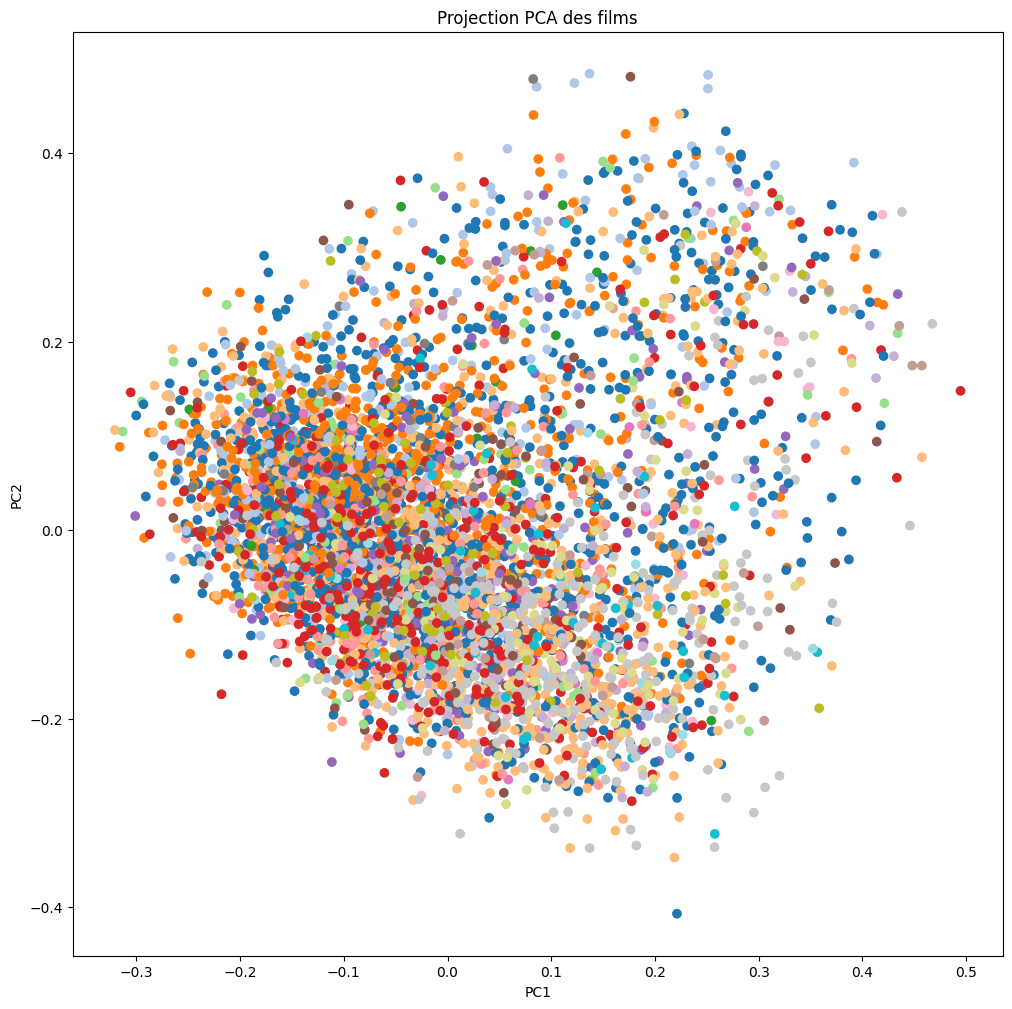

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convertir en dense (si dataset raisonnable)
X_dense = movie_vectors_array

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_dense)

plt.figure(figsize=(12, 12))
plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=pd.factorize(df_movies['main_genre'])[0],   # couleurs numériques
    cmap='tab20'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection PCA des films")
plt.show()


visualisation via UMAP

In [12]:
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 2.4 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.7 MB 3.0 MB/s eta 0:00:01
   -------------------------- ------------- 1.8/2.7 MB 3.0 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
    --------------------------------------- 0.5/38.1 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.3/38.1 MB 3.2 MB/s eta 0:00:12
   - -------------------------------------- 1.8/38.1 MB 3.1 MB/s eta 0:00:12
   -- ------------------------------------- 2.4/38.1 MB 3.1 MB/s eta 0:00:12
   --- ------------------------------------ 2.9/38.1 MB 3.1 MB/s eta 0:00:12
   --- -----------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


⏳ Réduction de dimension en cours (cela peut prendre un moment)...


d:\Nouveau dossier\envs\mltestenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


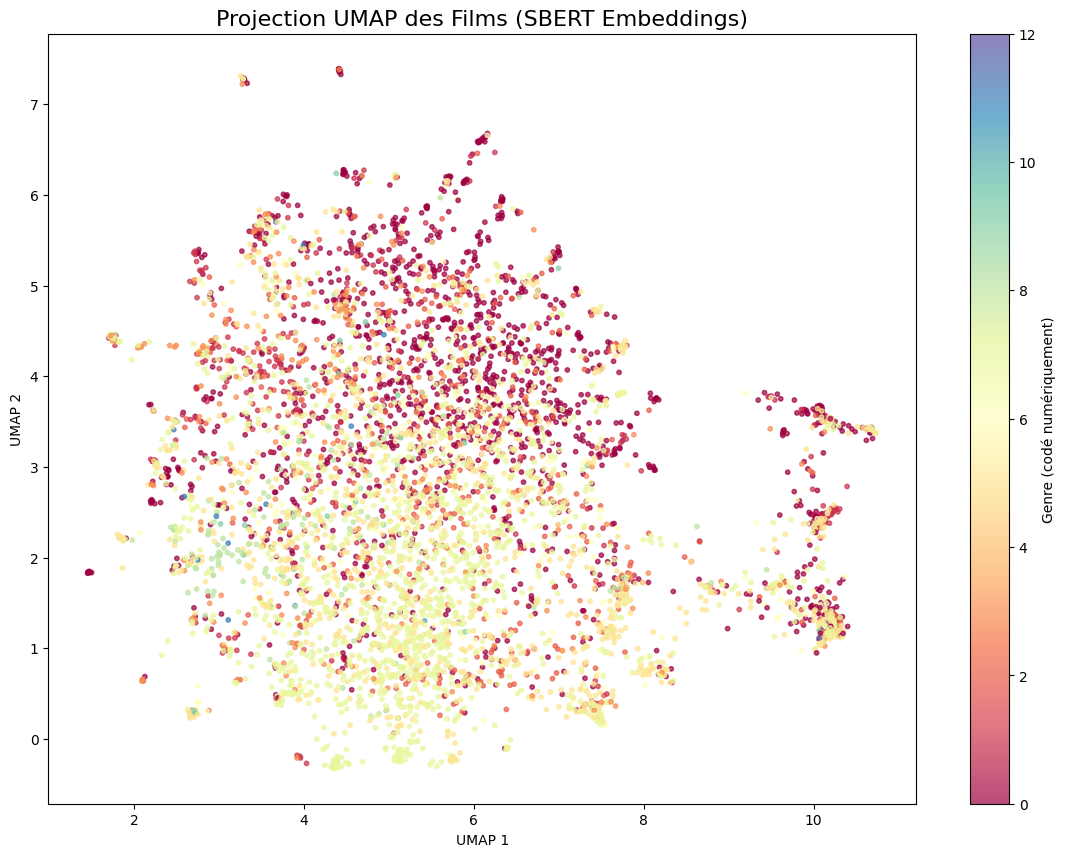

In [16]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
# Si tu préfères t-SNE, décommente la ligne ci-dessous
# from sklearn.manifold import TSNE

# 1. Configuration de UMAP
# n_neighbors : Contrôle la taille des clusters locaux (5-20 est bien pour du détail, 50+ pour une vue globale)
# min_dist : À quel point les points peuvent être serrés (0.1 est standard)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Pour t-SNE (alternative plus lente)
# reducer = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)

print("⏳ Réduction de dimension en cours (cela peut prendre un moment)...")
embedding_2d = reducer.fit_transform(movie_vectors_array)

# 2. Visualisation
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=pd.factorize(df_movies['main_genre'])[0], # Coloration par genre
    cmap='Spectral',
    s=10, # Taille des points réduite pour la clarté
    alpha=0.7 # Transparence pour voir les densités
)

plt.title('Projection UMAP des Films (SBERT Embeddings)', fontsize=16)
plt.colorbar(scatter, label='Genre (codé numériquement)')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


UMAP projete mieux les donnes dans l'espace reduit , il a réussi à regrouper les films qui se ressemblent selon le genre les uns à côté des autres

In [22]:

# 4. LOGIQUE DE RECOMMANDATION (La partie RAPIDE)

def get_recommendations(movie_titles: list, top_n=5):
    """
    Calcule le vecteur de profil utilisateur à partir d'une liste de films
    et trouve les top N films les plus similaires.
    """
    global df_movies, movie_title_to_index, movie_vectors_array
    
    if movie_vectors_array is None:
        print(" ERREUR : Le modèle n'a pas été initialisé. Exécutez initialize_and_encode() d'abord.")
        return []

    # 1. Récupérer les index des films sélectionnés
    try:
        indices_selected = [movie_title_to_index[title] for title in movie_titles]
    except KeyError as e:
        print(f"Film non trouvé dans la base de données: {e}")
        return []

    # 2. Créer le Vecteur de Profil Utilisateur (Agrégation)
    selected_vectors = movie_vectors_array[indices_selected]
    user_profile_vector = np.mean(selected_vectors, axis=0, keepdims=True)
    
    # 3. Comparaison (Cosine Similarity)
    # Comparer le vecteur profil (1 x D) à tous les films (N x D)
    scores_vector = cosine_similarity(user_profile_vector, movie_vectors_array)
    
    # 4. Trier et Filtrer
    scores = list(enumerate(scores_vector[0])) 
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Indices des films déjà sélectionnés pour l'exclusion
    selected_indices_set = set(indices_selected)
    recommendations_list = []
    
    for idx, score in sorted_scores:
        if idx not in selected_indices_set:
            # Ajouter le titre et le score
            recommendations_list.append({
                'title': df_movies.iloc[idx]['Movie_Title'],
                'score': score
            })
        
        if len(recommendations_list) >= top_n:
            break

    # 5. Affichage et retour
    print(f"\n--- Recommandations pour la sélection de {len(movie_titles)} films (Top {top_n}) ---")
    print(f"{'Score':<10} | {'Movie Title'}")
    print("-" * 40)
    for rec in recommendations_list:
        print(f"{rec['score']:.4f}     | {rec['title']}")
        
    return recommendations_list


# 5. EXÉCUTION POUR TESTER ET VÉRIFIER
if __name__ == "__main__":
    
    # --- ÉTAPE 1: Initialisation (Executez une seule fois) ---
    # Cette étape est longue car elle télécharge le modèle et calcule les 5449 vecteurs.
    #initialize_and_encode() 

    # --- ÉTAPE 2: Tests Répétitifs (Instantané) ---

    # Exemple 1: Profil Action/Thriller (The Dark Knight, Inception sont de bons exemples)
    action_thriller_selection = [
        'The Dark Knight', 
        'Inception', 
        '1 - Nenokkadine',
        'Mission: Impossible - Fallout',
        'Mad Max: Fury Road'
    ]
    get_recommendations(action_thriller_selection, top_n=5)

    # Exemple 2: Profil Animation/Famille
    animation_selection = [
        'Zootopia', 
        'Finding Nemo', 
        'Toy Story',
        'Inside Out'
    ]
    get_recommendations(animation_selection, top_n=5)
    
    # Exemple 3: Films de Drames Historiques
    drama_history_selection = [
        'Schindler\'s List',
        'The Pianist',
        '12 Years a Slave',
        'Lincoln',
        'A Beautiful Mind'
    ]
    get_recommendations(drama_history_selection, top_n=5)


--- Recommandations pour la sélection de 5 films (Top 5) ---
Score      | Movie Title
----------------------------------------
0.7323     | Basic
0.7166     | Mad Max
0.7125     | Darkman
0.7122     | War
0.7105     | 6 Underground

--- Recommandations pour la sélection de 4 films (Top 5) ---
Score      | Movie Title
----------------------------------------
0.7117     | Wildlife
0.6877     | Up
0.6848     | Sing
0.6801     | The Animal
0.6615     | 9

--- Recommandations pour la sélection de 5 films (Top 5) ---
Score      | Movie Title
----------------------------------------
0.6804     | The Master
0.6749     | World War Z
0.6621     | Sleuth
0.6611     | Wanted
0.6590     | American Gangster


In [27]:
action_thriller_selection = [
    'The Dark Knight', 
]
get_recommendations(action_thriller_selection, top_n=10)

# Exemple 2: Profil Animation/Famille
animation_selection = [
    'Zootopia', 
]
get_recommendations(animation_selection, top_n=3)

# Exemple 3: Films de Drames Historiques
drama_history_selection = [
    'A Beautiful Mind'
]
get_recommendations(drama_history_selection, top_n=5)


--- Recommandations pour la sélection de 1 films (Top 10) ---
Score      | Movie Title
----------------------------------------
0.8552     | The Dark Knight Rises
0.8442     | Batman
0.7501     | Batman Begins
0.7374     | The Batman
0.7129     | Batman: The Movie
0.6785     | Batman Returns
0.6735     | Batman: The Killing Joke
0.6573     | Joker
0.6520     | Batman Forever
0.6062     | Batman v Superman: Dawn of Justice

--- Recommandations pour la sélection de 1 films (Top 3) ---
Score      | Movie Title
----------------------------------------
0.7065     | We Bought a Zoo
0.6649     | Zookeeper
0.6372     | The Animal

--- Recommandations pour la sélection de 1 films (Top 5) ---
Score      | Movie Title
----------------------------------------
0.6095     | Jerry Maguire
0.5885     | The Master
0.5705     | A Single Man
0.5587     | The Dilemma
0.5537     | Maps to the Stars


[{'title': 'Jerry Maguire', 'score': 0.60953707},
 {'title': 'The Master', 'score': 0.58853567},
 {'title': 'A Single Man', 'score': 0.5705012},
 {'title': 'The Dilemma', 'score': 0.5587212},
 {'title': 'Maps to the Stars', 'score': 0.5536554}]